In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from pathlib import Path
import pandas as pd
import seaborn as sns

## Test run

Test run sanity check for the Left Cerebral White Matter, to see whether images are aligned and to test the calculation.

In [15]:
seg1_img = nib.load("../../Datasets/BOB/sub-116056/ses-3mo/anat/segmentation_outputs/002_Left-Cerebral-White-Matter.nii.gz")
seg2_img = nib.load("../../Datasets/BOB_segmented/sub-116056/ses-3mo/anat/segmentation_outputs/002_Left-Cerebral-White-Matter.nii.gz")

In [4]:
print(seg1_img.shape)
print(seg1_img.shape)

(182, 218, 182)
(182, 218, 182)


In [5]:
# Compare affine matrices
affine1 = seg1_img.affine
affine2 = seg2_img.affine

print("Affine 1:\n", affine1)
print("Affine 2:\n", affine2)

if np.allclose(affine1, affine2):
    print("Affine matrices are the same — images are voxel-wise aligned.")
else:
    print("WARNING: Affine matrices differ — images may not be aligned!")


Affine 1:
 [[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Affine 2:
 [[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
Affine matrices are the same — images are voxel-wise aligned.


In [16]:
# get segmentation data as boolean arrays
seg1 = seg1_img.get_fdata() > 0
seg2 = seg2_img.get_fdata() > 0

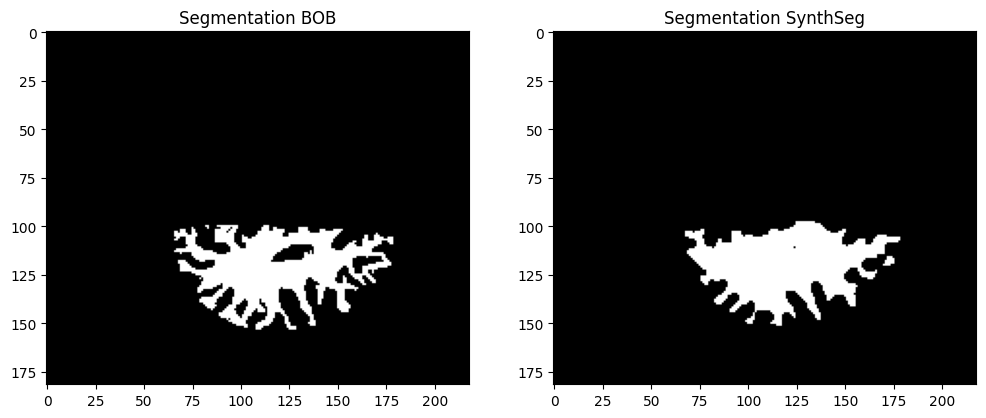

In [17]:
slice_index = seg1.shape[2] // 2  # Mid-slice in the z-dimension

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(seg1[:, :, slice_index], cmap='gray')
plt.title("Segmentation BOB")

plt.subplot(1, 2, 2)
plt.imshow(seg2[:, :, slice_index], cmap='gray')
plt.title("Segmentation SynthSeg")
plt.show()


## Metrics

### Intersection over Union (IoU)

The IoU (also known as the Jaccard Index) measures the overlap between two sets:

$$
\text{IoU}(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A| + |B| - |A \cap B|}
$$


- $A$ and $B$ are the binary masks.
- $|A \cap B|$: intersection (common positive voxels)
- $|A \cup B|$: union of all positive voxels



In [8]:
def compute_iou_3d(seg1, seg2):
    """
    Compute the Intersection over Union (IoU) for two binary segmentations.
    """
    intersection = np.logical_and(seg1, seg2).sum()
    union = np.logical_or(seg1, seg2).sum()
    if union == 0:
        return float('nan')  # Avoid division by zero
    return intersection / union


### Dice score

$$
\text{Dice}(A, B) = \frac{2 \cdot |A \cap B|}{|A| + |B|}
$$

- $A$ and $B$ are the binary masks.
- $|A \cap B|$: number of voxels shared by both masks.
- $|A|$, $|B|$: number of voxels in each individual mask.
- Ranges from 0 (no overlap) to 1 (perfect match).


In [9]:
def dice_score(seg1, seg2):
    """
    Compute the Dice score between two binary segmentations.
    """
    
    intersection = np.logical_and(seg1, seg2).sum()
    volume_sum = seg1.sum() + seg2.sum()
    
    if volume_sum == 0:
        return float('nan')  # Avoid division by zero if both are empty
    
    return 2 * intersection / volume_sum

### Hausdorff distance

$$
\text{HD}(A, B) = \max \left\{ \sup_{a \in A} \inf_{b \in B} d(a, b), \ \sup_{b \in B} \inf_{a \in A} d(b, a) \right\}
$$

- $d(a, b)$ is the Euclidean distance between boundary points $a \in A$ and $b \in B$.
- Measures the **maximum** surface mismatch between two segmentations.
- Sensitive to outliers — often complemented by **HD95**, the 95th percentile.

In [10]:
def hausdorff_distance_3d(seg1, seg2):
    # Convert numpy to SimpleITK images
    seg1_img = sitk.GetImageFromArray(seg1.astype(np.uint8))
    seg2_img = sitk.GetImageFromArray(seg2.astype(np.uint8))
    
    # Compute Hausdorff distance filter
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_filter.Execute(seg1_img, seg2_img)
    
    return hausdorff_filter.GetHausdorffDistance()


In [11]:
def hausdorff_95(seg1, seg2, spacing=(1.0, 1.0, 1.0)):
    """
    Compute the 95th percentile Hausdorff distance (HD95) between two binary segmentations.
    
    Parameters:
    - seg1, seg2: binary NumPy arrays (same shape)
    - spacing: voxel spacing in mm, tuple of (x, y, z), from image header if available

    Returns:
    - HD95 in physical units (e.g., mm)
    """
    # Convert NumPy to SimpleITK
    seg1_img = sitk.GetImageFromArray(seg1.astype(np.uint8))
    seg2_img = sitk.GetImageFromArray(seg2.astype(np.uint8))
    seg1_img.SetSpacing(spacing)
    seg2_img.SetSpacing(spacing)

    # Compute the surface distance map from each segmentation to the other
    def surface_distance_map(seg_a, seg_b):
        a_distance_map = sitk.SignedMaurerDistanceMap(seg_a, squaredDistance=False, useImageSpacing=True)
        b_surface = sitk.LabelContour(seg_b)
        return np.abs(sitk.GetArrayFromImage(a_distance_map))[sitk.GetArrayFromImage(b_surface) == 1]

    distances_1_to_2 = surface_distance_map(seg1_img, seg2_img)
    distances_2_to_1 = surface_distance_map(seg2_img, seg1_img)

    all_surface_distances = np.concatenate((distances_1_to_2, distances_2_to_1))

    if all_surface_distances.size == 0:
        return float('nan')  # no surface points to compare

    return np.percentile(all_surface_distances, 95)


### Mutual Information (MI)

$$
\text{MI}(A, B) = \sum_{a \in A} \sum_{b \in B} p(a, b) \cdot \log \left( \frac{p(a, b)}{p(a) \cdot p(b)} \right)
$$

- $A$ and $B$ are the segmentation masks (binary or labeled).
- $p(a)$ and $p(b)$ are the marginal probabilities of labels in $A$ and $B$.
- $p(a, b)$ is the joint probability of observing label $a$ in $A$ and label $b$ in $B$.
- MI measures how much knowing $A$ reduces uncertainty about $B$.


In [12]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score

def mutual_information(seg1, seg2):
    # Flatten to 1D arrays
    seg1_flat = seg1.ravel()
    seg2_flat = seg2.ravel()
    
    # Compute mutual information
    return mutual_info_score(seg1_flat, seg2_flat)

### Normalized Mutual Information (NMI)

$$
\text{NMI}(A, B) = \frac{2 \cdot \text{MI}(A, B)}{H(A) + H(B)}
$$

- $\text{MI}(A, B)$ is the mutual information between $A$ and $B$.
- $H(A)$ and $H(B)$ are the entropies of $A$ and $B$:
  $$
  H(X) = -\sum_x p(x) \cdot \log(p(x))
  $$
- NMI ranges from 0 (no similarity) to 1 (perfect match).


In [13]:
def compute_nmi(seg1, seg2):
    """
    Compute Normalized Mutual Information (NMI) between two segmentation masks.

    Parameters:
    - seg1, seg2: NumPy arrays of same shape (binary or integer labels)

    Returns:
    - NMI value (float, 0 to 1)
    """
    seg1_flat = seg1.ravel()
    seg2_flat = seg2.ravel()
    return normalized_mutual_info_score(seg1_flat, seg2_flat)


### Calculation

In [14]:
iou_score = compute_iou_3d(seg1, seg2)
print(f"3D IoU: {iou_score:.4f}")

# Compute Dice score
score = dice_score(seg1, seg2)
print(f"Dice Score: {score:.4f}")

print(f"Hausdorff Distance (3D): {hausdorff_distance_3d(seg1, seg2):.2f}")

spacing = list(map(float, seg1_img.header.get_zooms()[:3]))
print(f"Hausdorff Distance (95th percentile): {hausdorff_95(seg1, seg2, spacing=spacing):.2f} mm")

# Compute mutual information
mi_score = mutual_information(seg1, seg2)
print(f"Mutual Information: {mi_score:.4f}")

nmi_value = compute_nmi(seg1, seg2)
print(f"Normalized Mutual Information (NMI): {nmi_value:.4f}")

3D IoU: 0.5899
Dice Score: 0.7420
Hausdorff Distance (3D): 68.43
Hausdorff Distance (95th percentile): 2.83 mm
Mutual Information: 0.0543
Normalized Mutual Information (NMI): 0.5555


## Loop over all segmentations

In [22]:
results = []

# define both segmentation folders
segmentation1_base = Path("../../Datasets/BOB")
segmentation2_base = Path("../../Datasets/BOB_segmented")

for seg1_dseg in segmentation1_base.rglob("*dseg.nii.gz"):
    participant = seg1_dseg.parents[2].name
    session     = seg1_dseg.parents[1].name

    seg2_dseg = segmentation2_base / participant / session / "anat" / f"{participant}_{session}_space-INFANTMNIacpc_T1w.nii.gz"
    
    if not seg2_dseg.exists():
        print(f"Missing: {seg2_dseg}")
        continue

    # Folder with masks for each method
    mask_dir_1 = seg1_dseg.parent / "segmentation_outputs"
    mask_dir_2 = seg2_dseg.parent / "segmentation_outputs"
    
    if not (mask_dir_1.exists() and mask_dir_2.exists()):
        print(f"Missing masks for {participant} {session}")
        continue

    for mask_fp1 in mask_dir_1.glob("*.nii.gz"):
        stem = mask_fp1.stem
        try:
            lbl_str, name = stem.split("_", 1)
            lbl = int(lbl_str)
        except ValueError:
            print(f"Skipping mask with unexpected name: {stem}")
            continue

        mask_fp2 = mask_dir_2 / f"{lbl_str}_{name}.gz"
        if not mask_fp2.exists():
            print(f"No matching mask for {mask_fp1.name} in second method")
            continue

        # Load and binarize masks
        mask1 = nib.load(mask_fp1).get_fdata() > 0
        mask2 = nib.load(mask_fp2).get_fdata() > 0
        spacing = list(map(float, nib.load(mask_fp1).header.get_zooms()[:3]))
        

        # Compute metrics
        metrics = {
            "Dice": dice_score(mask1, mask2),
            "IoU":  compute_iou_3d(mask1, mask2),
            "Hausdorff": hausdorff_distance_3d(mask1, mask2),
            "HD95": hausdorff_95(mask1, mask2, spacing=spacing),
            "MI": mutual_information(mask1, mask2),
            "NMI": compute_nmi(mask1, mask2),
        }

        for metric_name, value in metrics.items():
            results.append({
                "participant_id": participant,
                "session_id": session,
                "label": lbl,
                "name": name,
                "metric": metric_name,
                "value": value
            })



No matching mask for 031_Left-choroid-plexus.nii.gz in second method
No matching mask for 063_Right-choroid-plexus.nii.gz in second method
No matching mask for 172_Vermis.nii.gz in second method
No matching mask for 031_Left-choroid-plexus.nii.gz in second method
No matching mask for 063_Right-choroid-plexus.nii.gz in second method
No matching mask for 172_Vermis.nii.gz in second method
No matching mask for 030_Left-vessel.nii.gz in second method
No matching mask for 031_Left-choroid-plexus.nii.gz in second method
No matching mask for 062_Right-vessel.nii.gz in second method
No matching mask for 063_Right-choroid-plexus.nii.gz in second method
No matching mask for 077_WM-hypointensities.nii.gz in second method
No matching mask for 085_Optic-Chiasm.nii.gz in second method
No matching mask for 030_Left-vessel.nii.gz in second method
No matching mask for 031_Left-choroid-plexus.nii.gz in second method
No matching mask for 062_Right-vessel.nii.gz in second method
No matching mask for 063_R

In [ ]:
df_segmentation = pd.DataFrame(results)

df_segmentation['name'] = (
    df_segmentation['name']
      .str.replace(".nii", "")
)

df_segmentation.to_csv("segmentation_metrics.csv", index=False)

In [2]:
df_segmentation = pd.read_csv("segmentation_metrics.csv")

In [7]:
df_segmentation.head()

,participant_id,session_id,label,name,metric,value
0,sub-116056,ses-3mo,2,Left-Cerebral-White-Matter,Dice,0.742034
1,sub-116056,ses-3mo,2,Left-Cerebral-White-Matter,IoU,0.589868
2,sub-116056,ses-3mo,2,Left-Cerebral-White-Matter,Hausdorff,68.432448
3,sub-116056,ses-3mo,2,Left-Cerebral-White-Matter,HD95,2.828427
4,sub-116056,ses-3mo,2,Left-Cerebral-White-Matter,MI,0.054265


### Plots

In [20]:
def assign_color(label_name):
    if 'Left' in label_name:
        return '#648FFF'
    elif 'Right' in label_name:
        return '#DC267F'
    elif 'whole_brain' in label_name:
        return '#FFB000'
    else:
        return 'grey'

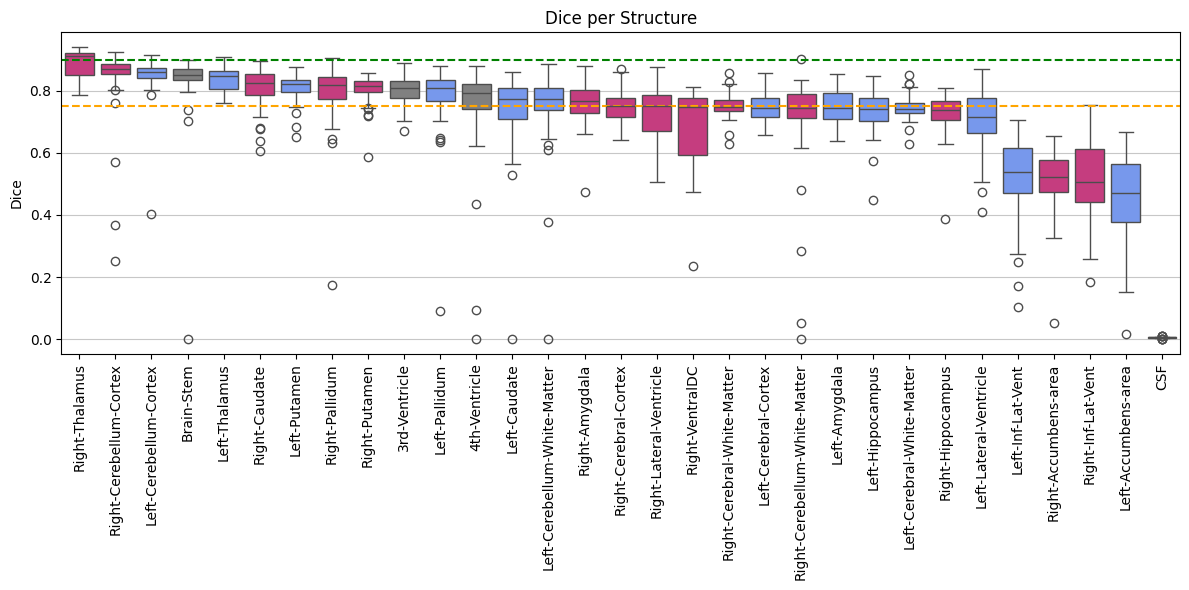

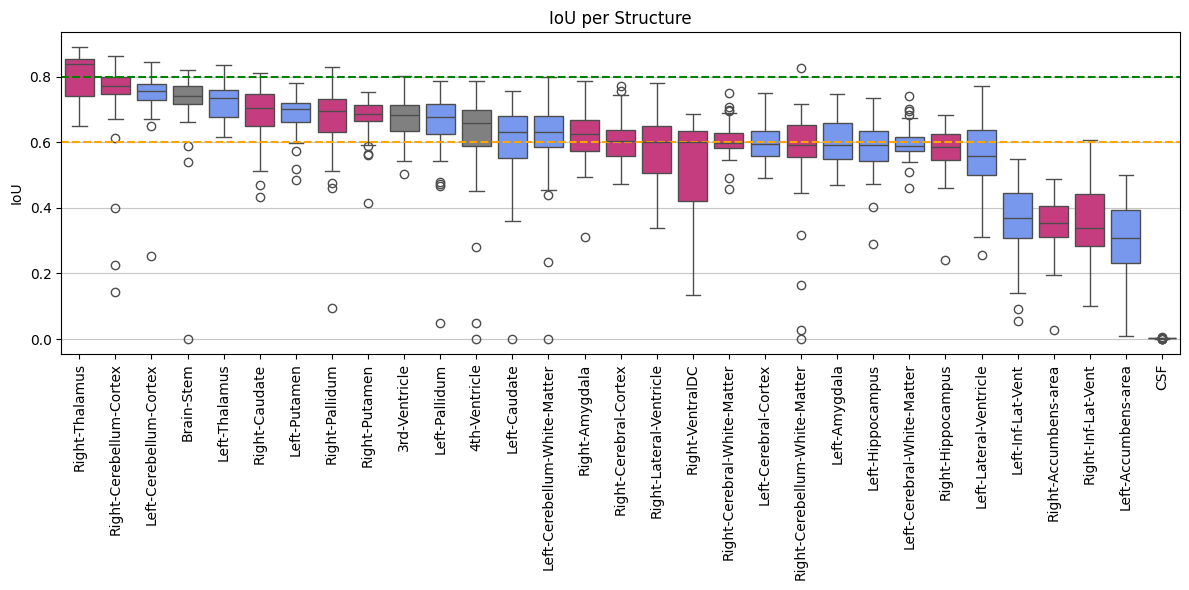

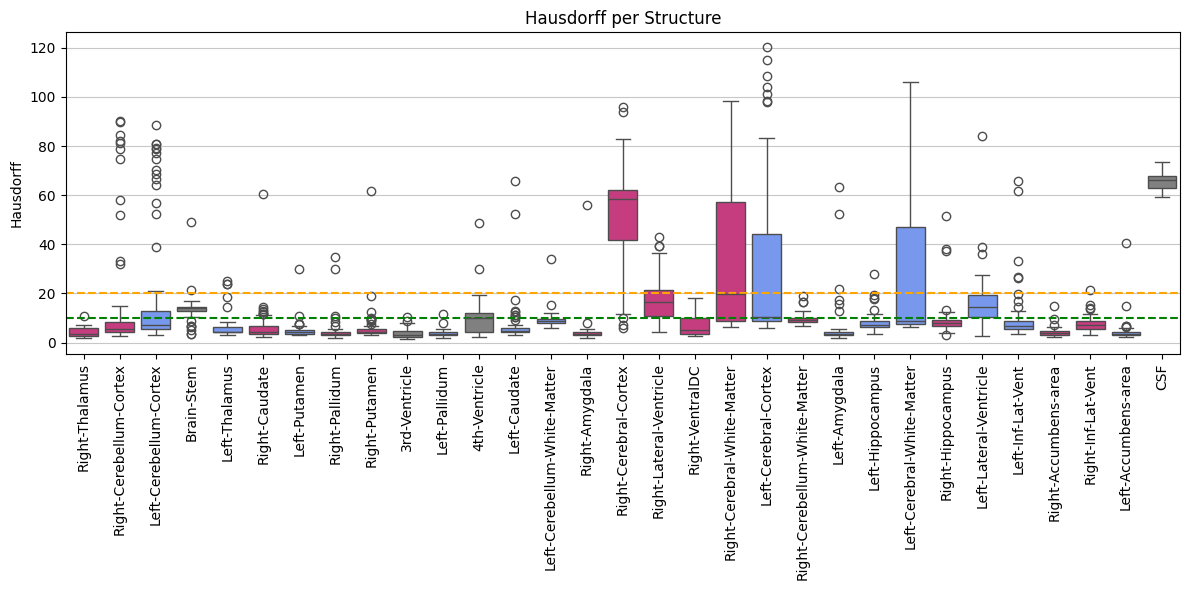

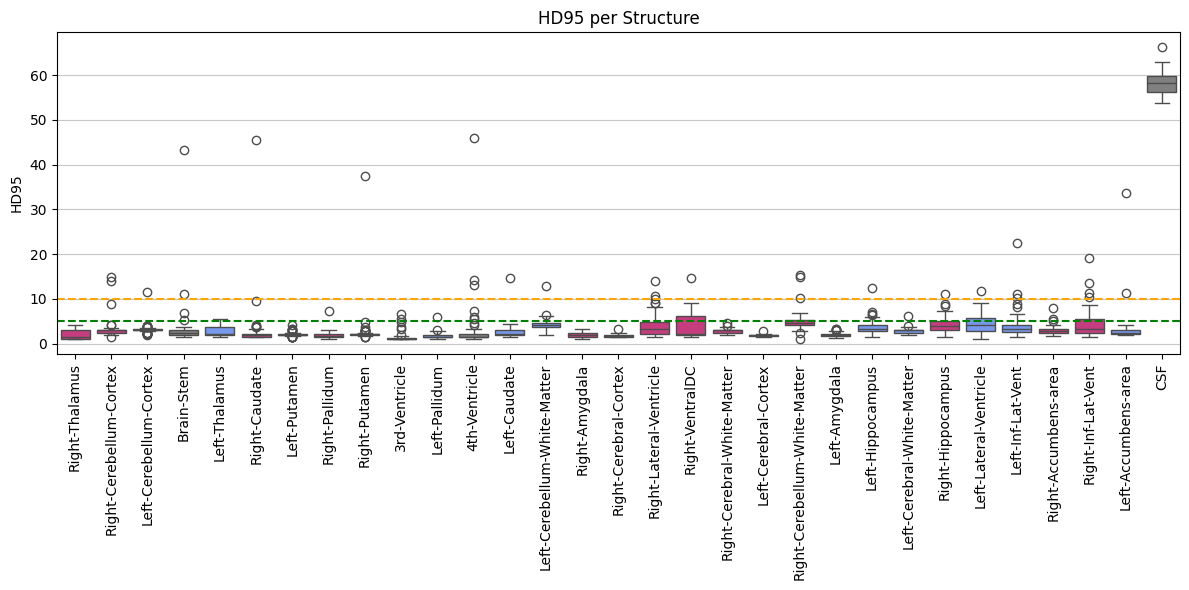

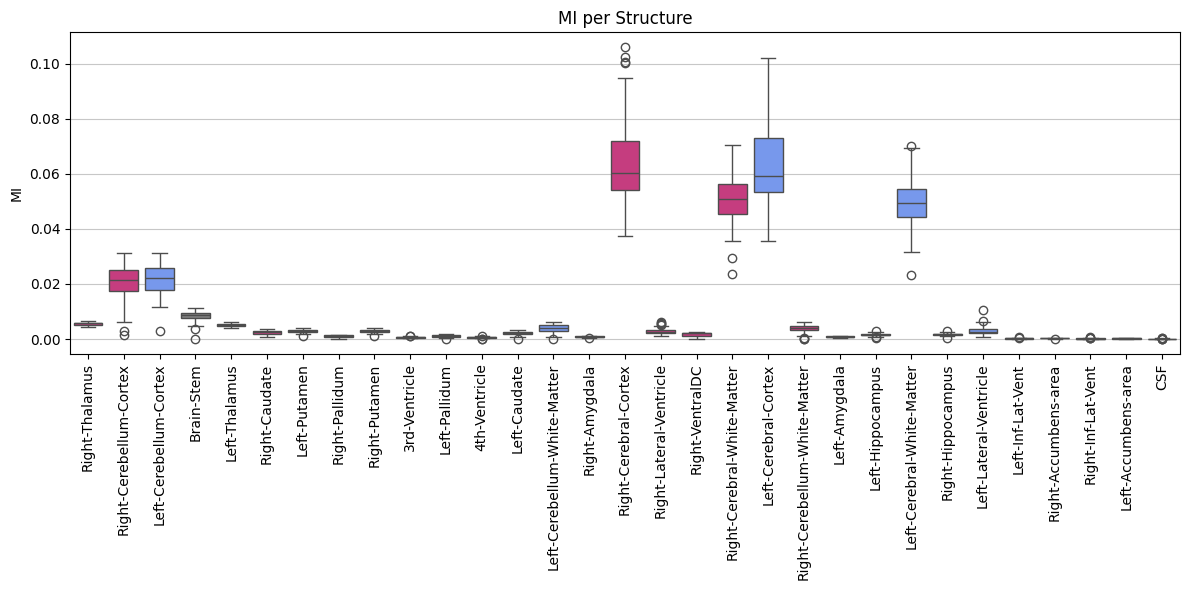

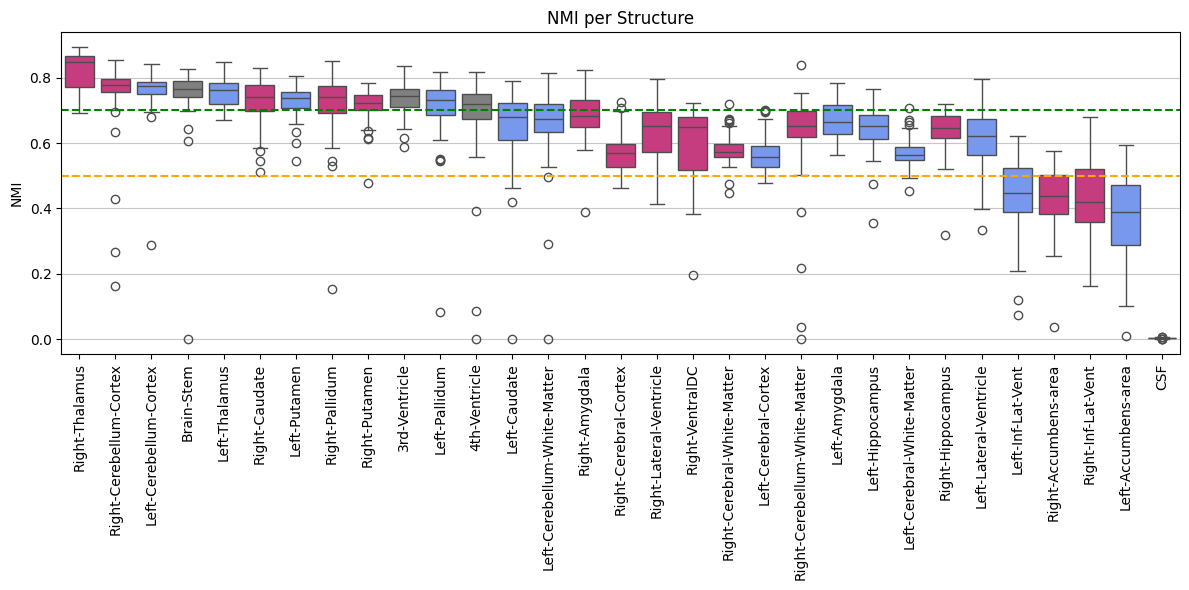

In [24]:
metrics_to_plot = df_segmentation['metric'].unique()

dice_medians = (df_segmentation[df_segmentation['metric'] == 'Dice']
                .groupby('name')['value']
                .median()
                .sort_values(ascending=False))
ordered_structures = dice_medians.index.tolist()

colors = [assign_color(r) for r in ordered_structures]
structure_palette = dict(zip(ordered_structures, colors))

thresholds = {
    'Dice': [0.75, 0.90],
    'IoU': [0.60, 0.80],
    'HD95': [10, 5],
    'Hausdorff': [20, 10],
    'NMI': [0.5, 0.7]
}

colors = ['orange', 'green']

# Loop through each metric and plot separately
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_segmentation[df_segmentation['metric'] == metric],
                x='name', y='value', order=ordered_structures,
                palette=structure_palette, hue='name')
    if metric in thresholds.keys():
        for thresh, color in zip(thresholds[metric], colors):
            plt.axhline(thresh, color=color, linestyle='--')
    plt.title(f"{metric} per Structure")
    plt.ylabel(metric)
    plt.xlabel("")
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    plt.show()


### Scatterplots for correlations

Exploring the correlation between the different scores.

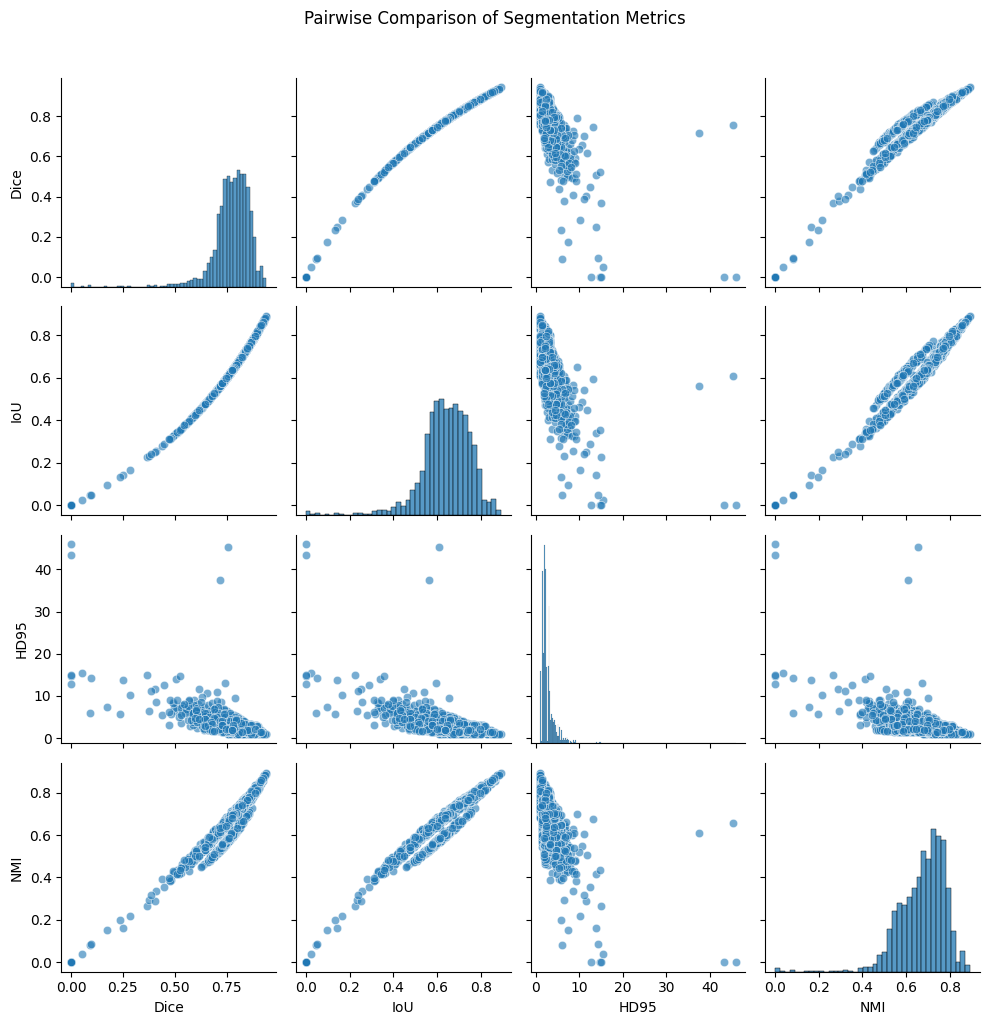

In [28]:
excluded_structures = [
    'Left-Inf-Lat-Vent',
    'Right-Inf-Lat-Vent',
    'Left-Accumbens-area',
    'Right-Accumbens-area',
    'CSF'
]

# Pivot and filter
df_wide = df_segmentation.pivot_table(
    index=['participant_id', 'session_id', 'label', 'name'],
    columns='metric',
    values='value'
).reset_index()

# Filter out unwanted structures
df_filtered = df_wide[~df_wide['name'].isin(excluded_structures)]

# Keep only the metrics you want to compare
metrics_to_include = ['Dice', 'IoU', 'HD95', 'NMI']
df_filtered = df_filtered[metrics_to_include].dropna()


sns.pairplot(df_filtered, kind='scatter', plot_kws={'alpha': 0.6})
plt.suptitle("Pairwise Comparison of Segmentation Metrics", y=1.02)
plt.tight_layout()
plt.show()


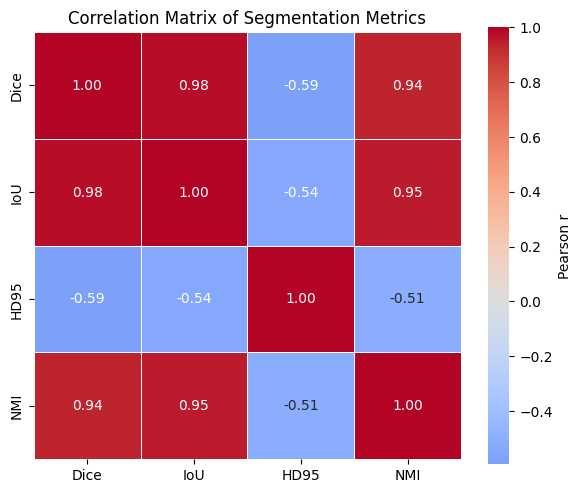

In [32]:
# Compute correlation matrix
corr_matrix = df_filtered[metrics_to_include].corr(method='pearson')

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'label': 'Pearson r'})
plt.title("Correlation Matrix of Segmentation Metrics")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()

## Volume

### Exploratory tests

In [3]:
vol_df = pd.read_csv(r"../../Datasets\BOB_segmented\sub-116056\ses-3mo\anat\sub-116056_ses-3mo_space-INFANTMNIacpc_T1w_vol.csv")
vol_df.head()

,Unnamed: 0,total intracranial,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,...,right cerebellum white matter,right cerebellum cortex,right thalamus,right caudate,right putamen,right pallidum,right hippocampus,right amygdala,right accumbens area,right ventral DC
0,sub-116056_ses-3mo_space-INFANTMNIacpc_T1w,926036.25,141239.11,180189.28,3037.668,274.725,4390.364,30670.338,6016.366,2068.422,...,4284.526,28841.809,6319.692,2128.169,3460.95,1017.048,2775.387,1195.089,510.229,2725.633


In [8]:
seg1_img = nib.load("../../Datasets/BOB/sub-116056/ses-3mo/anat/segmentation_outputs/002_Left-Cerebral-White-Matter.nii.gz")
seg2_img = nib.load("../../Datasets/BOB_segmented/sub-116056/ses-3mo/anat/segmentation_outputs/002_Left-Cerebral-White-Matter.nii.gz")

# Load and binarize masks
mask1 = seg1_img.get_fdata() > 0
mask2 = seg2_img.get_fdata() > 0

spacing = seg1_img.header.get_zooms()[:3] # mm
voxel_volume = spacing[0] * spacing[1] * spacing[2]  # mm³

volume1 = mask1.sum() * voxel_volume
volume2 = mask2.sum() * voxel_volume

print(f"Volume of segmentation BOB: {volume1:.0f} mm³")
print(f"Volume of segmentation SynthSeg: {volume2:.0f} mm³")
print(f"Volume of segmentation SynthSeg - output (csv): {vol_df.loc[0, 'left cerebral white matter']:.0f} mm³")


Volume of segmentation BOB: 147515 mm³
Volume of segmentation SynthSeg: 140019 mm³
Volume of segmentation SynthSeg - output (csv): 141239 mm³


Second test for the whole brain images.

In [10]:
seg1_img = nib.load("../../Datasets/BOB/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_desc-aseg_dseg.nii.gz")
seg2_img = nib.load("../../Datasets/BOB_segmented/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz")

# Load and binarize masks
mask1 = seg1_img.get_fdata() > 0
mask2 = seg2_img.get_fdata() > 0

spacing1 = seg1_img.header.get_zooms()[:3] # mm
voxel_volume1 = spacing1[0] * spacing1[1] * spacing1[2]  # mm³

spacing2 = seg2_img.header.get_zooms()[:3] # mm
voxel_volume2 = spacing2[0] * spacing2[1] * spacing2[2]  # mm³

volume1 = mask1.sum() * voxel_volume1
volume2 = mask2.sum() * voxel_volume2

print(f"Volume of segmentation BOB: {volume1:.0f} mm³")
print(f"Volume of segmentation SynthSeg: {volume2:.0f} mm³")

Volume of segmentation BOB: 713007 mm³
Volume of segmentation SynthSeg: 928871 mm³


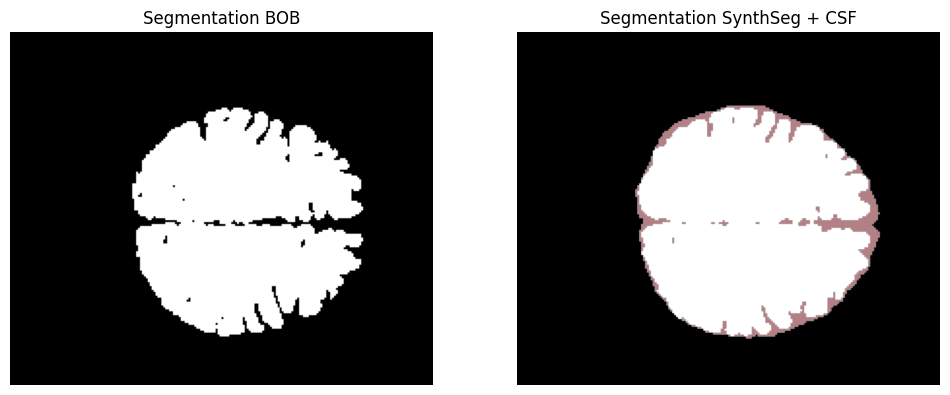

In [ ]:
slice_index = mask1.shape[2] // 2  # Mid-slice in the z-dimension

# Load the overlay mask (CSF)
csf_mask_img = nib.load(r"../../Datasets\BOB_segmented\sub-116056\ses-3mo\anat\segmentation_outputs\024_CSF.nii.gz")
csf_mask = csf_mask_img.get_fdata() > 0

# Get the slices
slice_mask2 = mask2[:, :, slice_index]
slice_csf = csf_mask[:, :, slice_index]

# Create a masked version of the CSF mask so background stays transparent
csf_mask_masked = np.ma.masked_where(slice_csf == 0, slice_csf)

# Plot
plt.figure(figsize=(12, 5))

# Base segmentation (BOB)
plt.subplot(1, 2, 1)
plt.imshow(mask1[:, :, slice_index], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title("Segmentation BOB")

# Second segmentation (SynthSeg) + CSF overlay
plt.subplot(1, 2, 2)
plt.imshow(slice_mask2, cmap='gray')
plt.imshow(csf_mask_masked, cmap='Reds', vmin=0, vmax=1, alpha=0.5)  # only show overlay where CSF > 0
plt.axis('off')
plt.title("Segmentation SynthSeg + CSF")
plt.show()


For the whole brain, difference are huge, because not only the brain is present but also layers between the brain and the skull. If we want to compare those, we likely need to substract the whole brain minus CSF.

In [35]:
# Subtract CSF from SynthSeg segmentation by zeroing CSF voxels
mask2_without_csf = mask2 & ~csf_mask  # keep voxels that are in mask2 but not in CSF

# Recalculate volume without CSF
volume2_no_csf = mask2_without_csf.sum() * voxel_volume2

print(f"Volume of segmentation BOB: {volume1:.0f} mm³")
print(f"Volume of segmentation SynthSeg (with CSF): {volume2:.0f} mm³")
print(f"Volume of segmentation SynthSeg (without CSF): {volume2_no_csf:.0f} mm³")

volume_diff = abs(volume1 - volume2)
volume_ratio = volume1 / volume2 if volume2 > 0 else float('inf')
print("\nVolume difference and ratio (incl. CSF):")
print(f"Volume difference: {volume_diff:.0f} mm³")
print(f"Volume ratio (BOB / SynthSeg): {volume_ratio:.2f}")

volume_diff_csf = abs(volume1 - volume2_no_csf)
volume_ratio_csf = volume1 / volume2_no_csf if volume2_no_csf > 0 else float('inf')
print("\nVolume difference and ratio (without CSF):")
print(f"Volume difference: {volume_diff_csf:.0f} mm³")
print(f"Volume ratio (BOB / SynthSeg): {volume_ratio_csf:.2f}")

Volume of segmentation BOB: 713007 mm³
Volume of segmentation SynthSeg (with CSF): 928871 mm³
Volume of segmentation SynthSeg (without CSF): 772013 mm³

Volume difference and ratio (incl. CSF):
Volume difference: 215864 mm³
Volume ratio (BOB / SynthSeg): 0.77

Volume difference and ratio (without CSF):
Volume difference: 59006 mm³
Volume ratio (BOB / SynthSeg): 0.92


We still observe a difference but results seem more reasonable now.